# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. 

We **avoid overfitting through regularization such as dropout** while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [15]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here I'll create a model like normal, using the same one from my solution for part 4.

In [16]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [17]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
logps = model(images)
ps = torch.exp(logps)

# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [18]:
top_p, top_class = ps.topk(1, dim=1)

# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])
print(top_p[:10,:])

tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [5],
        [4],
        [5],
        [5],
        [5]])
tensor([[0.1144],
        [0.1135],
        [0.1100],
        [0.1132],
        [0.1108],
        [0.1149],
        [0.1153],
        [0.1177],
        [0.1145],
        [0.1142]], grad_fn=<SliceBackward>)


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [19]:
equals = top_class == labels.view(*top_class.shape) # <-- why the asterisk?

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [20]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 3.125%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [21]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    print('Epoch', e)
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        # turn off gradients
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            # validation pass here
            for images, labels in testloader:
                log_ps = model.forward(images)
                ps = torch.exp(log_ps)
                
                loss = criterion(log_ps, labels)
                test_loss += loss
                
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print('Training loss: {:.4f}'.format(running_loss / len(trainloader)))
        print('Test loss: {:.4f}'.format(test_loss / len(testloader)))
        print('Test accuracy: {:.4f}'.format(accuracy / len(testloader)))

Epoch 0
Training loss: 0.5117
Test loss: 0.4505
Test accuracy: 0.8355
Epoch 1
Training loss: 0.3895
Test loss: 0.4200
Test accuracy: 0.8531
Epoch 2
Training loss: 0.3597
Test loss: 0.3948
Test accuracy: 0.8608
Epoch 3
Training loss: 0.3339
Test loss: 0.3677
Test accuracy: 0.8709
Epoch 4
Training loss: 0.3166
Test loss: 0.3755
Test accuracy: 0.8665
Epoch 5
Training loss: 0.3013
Test loss: 0.3779
Test accuracy: 0.8652
Epoch 6
Training loss: 0.2913
Test loss: 0.3904
Test accuracy: 0.8627
Epoch 7
Training loss: 0.2827
Test loss: 0.3579
Test accuracy: 0.8750
Epoch 8
Training loss: 0.2736
Test loss: 0.3734
Test accuracy: 0.8703
Epoch 9
Training loss: 0.2720
Test loss: 0.3985
Test accuracy: 0.8653
Epoch 10
Training loss: 0.2634
Test loss: 0.3809
Test accuracy: 0.8709
Epoch 11
Training loss: 0.2558
Test loss: 0.3701
Test accuracy: 0.8718
Epoch 12
Training loss: 0.2469
Test loss: 0.3523
Test accuracy: 0.8794
Epoch 13
Training loss: 0.2425
Test loss: 0.3696
Test accuracy: 0.8808
Epoch 14
Trainin

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

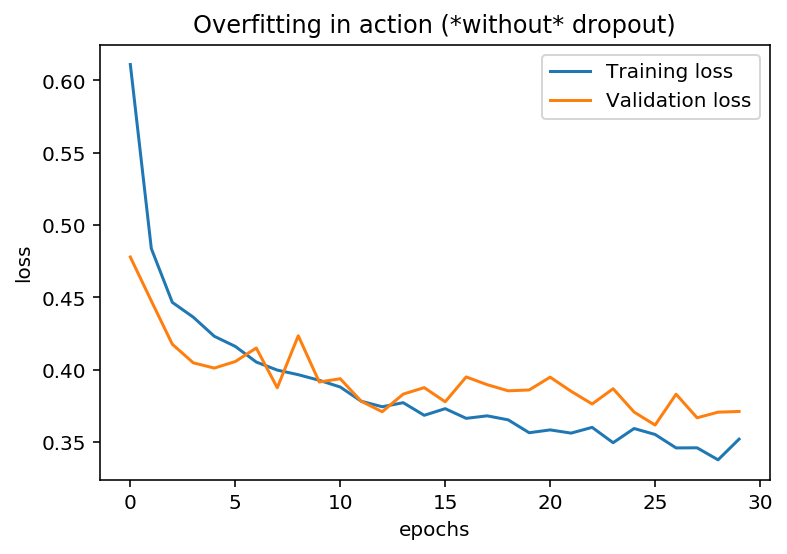

In [42]:
plt.plot(range(epochs), train_losses, label='Training loss')
plt.plot(range(epochs), test_losses, label='Validation loss')
plt.title('Overfitting in action (*without* dropout)')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible.

One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called ***early-stopping***. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

**During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network.**

So, we need to **turn off dropout during validation, testing**, and whenever we're using the network to make **predictions**. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [36]:
## TODO: Define your model with dropout added
import torch
from torch import nn
import torch.nn.functional as F

input_dims = 28*28
hidden_dims = [256, 128, 64]
output_dims = 10


class FMNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dims = 28*28
        self.hidden_dims = [256, 128, 64]
        self.output_dims = 10
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(input_dims, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dims)
    
    def forward(self, x):
        x = x.view(x.shape[0], input_dims)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        out = self.logsoftmax(x)
        
        return out

In [38]:
## TODO: Train your model **with dropout**, and monitor the training progress with the validation loss and accuracy
from torch import optim


model = FMNISTNet()
optimizer = optim.Adam(model.parameters(), lr=0.003)
#optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

epochs = 30
train_losses, test_losses = [], []

for e in range(epochs):
    print('epoch', e)
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], input_dims)
        
        optimizer.zero_grad()

        logps = model.forward(images)
        loss = criterion(logps, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            # validation pass here
            model.eval() # turn on eval mode for model
            for images, labels in testloader:
                log_ps = model.forward(images)
                ps = torch.exp(log_ps)

                loss = criterion(log_ps, labels)
                test_loss += loss

                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print('Training loss: {:.4f}'.format(running_loss / len(trainloader)))
            print('Test loss: {:.4f}'.format(test_loss / len(testloader)))
            print('Test accuracy: {:.4f}'.format(accuracy / len(testloader)))
            
    model.train() # turn on train mode for model

epoch 0
Training loss: 0.6110
Test loss: 0.4779
Test accuracy: 0.8279
epoch 1
Training loss: 0.4838
Test loss: 0.4476
Test accuracy: 0.8386
epoch 2
Training loss: 0.4466
Test loss: 0.4176
Test accuracy: 0.8459
epoch 3
Training loss: 0.4363
Test loss: 0.4048
Test accuracy: 0.8590
epoch 4
Training loss: 0.4231
Test loss: 0.4011
Test accuracy: 0.8597
epoch 5
Training loss: 0.4161
Test loss: 0.4057
Test accuracy: 0.8585
epoch 6
Training loss: 0.4053
Test loss: 0.4150
Test accuracy: 0.8546
epoch 7
Training loss: 0.3997
Test loss: 0.3875
Test accuracy: 0.8633
epoch 8
Training loss: 0.3966
Test loss: 0.4235
Test accuracy: 0.8558
epoch 9
Training loss: 0.3927
Test loss: 0.3915
Test accuracy: 0.8620
epoch 10
Training loss: 0.3880
Test loss: 0.3938
Test accuracy: 0.8662
epoch 11
Training loss: 0.3782
Test loss: 0.3782
Test accuracy: 0.8618
epoch 12
Training loss: 0.3744
Test loss: 0.3710
Test accuracy: 0.8721
epoch 13
Training loss: 0.3772
Test loss: 0.3831
Test accuracy: 0.8631
epoch 14
Trainin

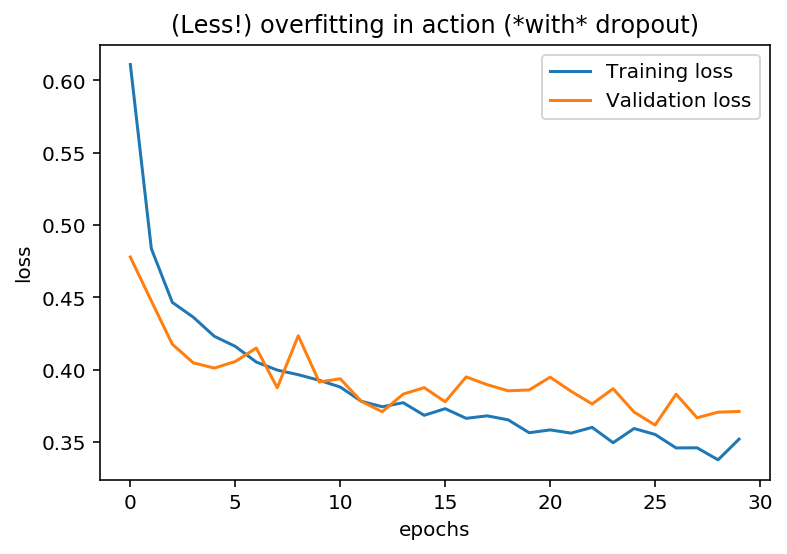

In [43]:
plt.plot(range(epochs), train_losses, label='Training loss')
plt.plot(range(epochs), test_losses, label='Validation loss')
plt.title('(Less!) overfitting in action (*with* dropout)')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

FMNISTNet(
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

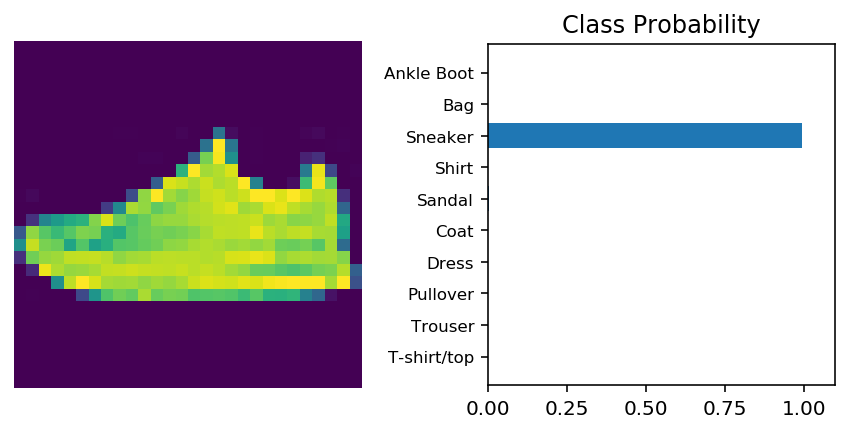

In [51]:
# Import helper module (should be in the repo)
import helper

# Turn eval mode on for model. Test out your network!
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
#with torch.no_grad():
#    for images, labels in testloader:
#        log_ps = model.forward(images)
#        ps = torch.exp(log_ps)

log_ps = model.forward(img)
ps = torch.exp(log_ps)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

# Turn training mode back on for model.
model.train()

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.